In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Installing Libraries

In [ ]:
!pip install chromadb
!pip install PyMuPDF
# !pip install -U langchain-community
# !pip install sentence-transformers
!pip install evaluate
!pip install smolagents
!pip install rouge_score
!pip install bert_score

### Importing Libraries

In [ ]:
import os
import glob
import fitz
import chromadb
import numpy as np
from typing import List
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
from evaluate import load
import matplotlib.pyplot as plt
from smolagents.tools import Tool
from typing import Dict, List, Union
import re
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch


# RAG Pipeline

## Inititallization

In [ ]:
EMBEDDING_MODEL = "all-MiniLM-L6-v2"
db_dir = "/content/drive/MyDrive/2CSI-Project_DATA/VectorDB_Embeddings"
data_dir = "/content/drive/MyDrive/Colab Notebooks/data"
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)

In [ ]:
# Initialize models
embedding_model = SentenceTransformer(EMBEDDING_MODEL)

In [ ]:
# Initialize ChromaDB
client = chromadb.PersistentClient(path=db_dir)
collection = client.get_or_create_collection(name='ties_collection_emb', metadata={"hnsw:space": "cosine"})

## Document Processing

In [ ]:

def process_scientific_text(text):
    # Remove references (e.g., [10], [15])
    text = re.sub(r'\[\d+\]', '', text)

    # Remove formulas (e.g., Lntp = ..., Lclass = ...)
    text = re.sub(r'L[a-zA-Z]+\s*=\s*[^=]+', '', text)

    # Remove table-related content (e.g., "TABLE 1. OVERVIEW OF THE DGA DATASET")
    text = re.sub(r'TABLE \d+\..*?\n', '', text, flags=re.IGNORECASE)

    # Remove numerical results (e.g., 97%, 0.7%, 1458863)
    text = re.sub(r'\b\d+%|\b\d+\.\d+%|\b\d{3,}\b', '', text)

    # Remove dataset-specific details (e.g., URLs, dataset sizes)
    text = re.sub(r'https?://[^\s]+', '', text)
    text = re.sub(r'\b\d+\s*(domains|records|samples|queries)\b', '', text, flags=re.IGNORECASE)

    # Remove lines with DGA dataset examples (e.g., zsvubwnqlefqv.com, xshellghost)
    text = re.sub(r'^\w+\s+\d+\s+[^\s]+\.[a-z]+$', '', text, flags=re.MULTILINE)

    # Remove empty lines and normalize whitespace, preserving section headings
    lines = [line.strip() for line in text.splitlines() if line.strip()]
    text = '\n'.join(lines)  # Preserve line breaks for section headings

    return text

## Chunking Document

In [ ]:
# PDF processing
def extract_and_chunk_pdf(file_path, chunk_size=800, chunk_overlap=400):
    """Extracts text from a PDF and splits into chunks."""
    doc = fitz.open(file_path)
    text = "\n".join([page.get_text("text") for page in doc])

    # Extract abstract (assuming it's the first paragraph or labeled)
    abstract = text.split("\n\n")[0] if "abstract" in text.lower() else ""



    # def extract_abstract(text):
    #   """
    #   Extracts the abstract section using stricter heading detection, avoiding look-behind.
    #   """
    #   # Match 'Abstract' as a heading (e.g., start of line), followed by text,
    #   # stopping at 'Introduction' or another heading-like pattern
    #   pattern = r'^\s*abstract\s*[\n:\-]*\s*(.*?)(?=\n\s*(\d{0,2}\.?\s*)?introduction\b|\n\s*[A-Z][^\n]{0,50}\n)'
    #   match = re.search(pattern, text, flags=re.IGNORECASE | re.DOTALL | re.MULTILINE)

    #   if match:
    #       abstract = match.group(1).strip()
    #       abstract = re.sub(r'\s+', ' ', abstract)  # Normalize whitespace
    #       return abstract
    #   return None

    # abstract = extract_abstract(text)
    # Chunk text
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    chunks = text_splitter.split_text(text)
    chunks = [process_scientific_text(chunk) for chunk in chunks]
    return chunks, abstract

def compute_embeddings(chunks):
    """ Computes embeddings for text chunks """
    return embedding_model.encode(chunks, convert_to_numpy=True)

def store_in_vector_db(chunks, file_path):
    """Stores chunks and embeddings in ChromaDB."""
    doc_id = os.path.basename(file_path)
    embeddings = compute_embeddings(chunks)

    for i, (chunk, embedding) in enumerate(zip(chunks, embeddings)):
        collection.add(
            ids=[f"{doc_id}_chunk_{i}"],
            documents=[chunk],
            embeddings=[embedding.tolist()],
            metadatas=[{"source": doc_id, "chunk_id": i}]
        )

    return len(chunks)

In [ ]:
chunks, abstract = extract_and_chunk_pdf(os.path.join(data_dir, "A Framework for Fine-Tuning LLMs using Heterogeneo.pdf"))

In [ ]:
print(chunks[0])

A Framework for Fine-Tuning LLMs using Heterogeneous Feedback
Ryan Aponte 1, Ryan A. Rossi 2, Shunan Guo2, Franck Dernoncourt2,
Tong Yu2, Xiang Chen2, Subrata Mitra2, Nedim Lipka 2
1Carnegie Mellon University, 2Adobe Research
Abstract
Large language models (LLMs) have been
applied to a wide range of tasks, including
text summarization, web navigation, and chat-
bots. They have benefitted from supervised
fine-tuning (SFT) and reinforcement learning
from human feedback (RLHF) following an un-
supervised pretraining. These datasets can be
difficult to collect, limited in scope, and vary in
sample quality. Additionally, datasets can vary
extensively in supervision format, from numer-
ical to binary as well as multi-dimensional with
many different values. We present a framework
for fine-tuning LLMs using heterogeneous feed-
back, which has two main components. First,
we combine the heterogeneous feedback data
into a single supervision format, compatible
with methods like SFT and RLHF. Next,

In [ ]:
print(abstract)

A Framework for Fine-Tuning LLMs using Heterogeneous Feedback
Ryan Aponte 1, Ryan A. Rossi 2, Shunan Guo2, Franck Dernoncourt2,
Tong Yu2, Xiang Chen2, Subrata Mitra2, Nedim Lipka 2
1Carnegie Mellon University, 2Adobe Research
Abstract
Large language models (LLMs) have been
applied to a wide range of tasks, including
text summarization, web navigation, and chat-
bots. They have benefitted from supervised
fine-tuning (SFT) and reinforcement learning
from human feedback (RLHF) following an un-
supervised pretraining. These datasets can be
difficult to collect, limited in scope, and vary in
sample quality. Additionally, datasets can vary
extensively in supervision format, from numer-
ical to binary as well as multi-dimensional with
many different values. We present a framework
for fine-tuning LLMs using heterogeneous feed-
back, which has two main components. First,
we combine the heterogeneous feedback data
into a single supervision format, compatible
with methods like SFT and RLHF. Next,

In [ ]:
def extract_sections(paper_text: str) -> str:
        """
        Extracts key sections from a scientific paper using regex.

        Args:
            paper_text (str): The full text of the scientific paper.

        Returns:
            str: A string containing the extracted sections formatted as "Section: Text".
        """
        sections = {}
        section_patterns = {
            "Abstract": r"(?i)^Abstract\n([\s\S]*?)(?=\n\n(?:Introduction|Methods|Results|Discussion|Conclusion|\Z))",
            "Introduction": r"(?i)^Introduction\n([\s\S]*?)(?=\n\n(?:Methods|Results|Discussion|Conclusion|\Z))",
            "Methods": r"(?i)^Methods\n([\s\S]*?)(?=\n\n(?:Results|Discussion|Conclusion|\Z))",
            "Results": r"(?i)^Results\n([\s\S]*?)(?=\n\n(?:Discussion|Conclusion|\Z))",
            "Discussion": r"(?i)^Discussion\n([\s\S]*?)(?=\n\n(?:Conclusion|\Z))",
            "Conclusion": r"(?i)^Conclusion\n([\s\S]*?)(?=\n\n|\Z)"
        }

        for section, pattern in section_patterns.items():
            match = re.search(pattern, paper_text, re.MULTILINE)
            if match:
                sections[section] = match.group(1).strip()

        if sections:
            sections_str = "\n\n".join([f"{key}:\n{value}" for key, value in sections.items()])
        else:
            sections_str = "Full Text:\n" + paper_text

        return sections_str

In [ ]:
def retrieve_similar_chunks(embeddings: np.ndarray, sections: str, top_k: int = 5) -> List[str]:
        """Retrieve top-k similar chunks from ChromaDB by matching each chunk separately."""

        client = chromadb.PersistentClient(path=db_dir)
        collection = client.get_or_create_collection(name='ties_collection_emb', metadata={"hnsw:space": "cosine"})
        doc_embedding = np.mean(embeddings, axis=0).tolist()
        results = collection.query(query_embeddings=[doc_embedding], n_results=top_k)
        chunks = results["documents"][0] if results["documents"] else []

        # Prioritize chunks from Abstract and Conclusion
        prioritized = []
        sections_lower = sections.lower()
        for chunk in chunks:
            if any(section in chunk.lower() for section in ["abstract", "conclusion"]) or any(section in sections_lower for section in ["abstract", "conclusion"]):
                prioritized.insert(0, chunk)
            else:
                prioritized.append(chunk)

        return prioritized[:top_k]


In [ ]:
doc = fitz.open(data_dir + "/A Framework for Fine-Tuning LLMs using Heterogeneo.pdf")
text = "\n".join([page.get_text("text") for page in doc])
sections = extract_sections(text)
a=retrieve_similar_chunks(compute_embeddings(chunks),sections, top_k=5)
print(a[0:2])

['Stoica, and Eric P. Xing. 2023. Vicuna: An open-\nsource chatbot impressing gpt-4 with 90%* chatgpt\nquality.\nAakanksha Chowdhery, Sharan Narang, Jacob Devlin,\nMaarten Bosma, Gaurav Mishra, Adam Roberts,\nPaul Barham, Hyung Won Chung, Charles Sutton,\nSebastian Gehrmann, et al. 2022. Palm: Scaling\nlanguage modeling with pathways. arXiv preprint\narXiv:2204.02311.\nEdward J Hu, Yelong Shen, Phillip Wallis, Zeyuan\nAllen-Zhu, Yuanzhi Li, Shean Wang, Lu Wang,\nand Weizhu Chen. 2021. Lora: Low-rank adap-\ntation of large language models. arXiv preprint\narXiv:2106.09685.\nPo-Nien Kung, Fan Yin, Di Wu, Kai-Wei Chang, and\nNanyun Peng. 2023. Active instruction tuning:\nImproving cross-task generalization by training on\nprompt sensitive tasks. Preprint, arXiv:2311.00288.\nAndreas Köpf, Yannic Kilcher, Dimitri von Rütte,\nSotiris Anagnostidis, Zhi-Rui Tam, Keith Stevens,\nAbdullah Barhoum, Nguyen Minh Duc, Oliver\nStanley, Richárd Nagyfi, Shahul ES, Sameer Suri,\nDavid Glushkov, Arnav Da

## Baseline : T5-Small summarization

In [ ]:
t5_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

def baseline_model(pdf_path):
    """Baseline: Summarizes PDF chunks without RAG using flan-t5-base."""
    pdf_chunks = extract_and_chunk_pdf(pdf_path)[0]
    context = " ".join(pdf_chunks)

    # T5-friendly format
    prompt = f"summarize: {context}"

    # Tokenize and summarize
    inputs = t5_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(
        inputs["input_ids"],
        max_length=200,
        min_length=50,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
summary = baseline_model(os.path.join(data_dir, "2488552.pdf"))
print(summary)

We show how a higher-frequency momentum overlay can reduce the risks induced by rebalancing by improving the timing of the rebalancing. This smart rebalancing, which incorporates a momentum overlay, shows relatively stable portfolio weights and reduced drawdowns.


## RAG Summarization

In [ ]:
def classical_rag(pdf_path, user_query):
    """Classical RAG using T5-small: retrieves relevant chunks and summarizes them."""
    # Extract and process PDF
    pdf_chunks = extract_and_chunk_pdf(pdf_path)[0]
    sections = extract_sections("\n".join(pdf_chunks))

    # Retrieve relevant context
    results = retrieve_similar_chunks(compute_embeddings(pdf_chunks), sections, top_k=5)

    # Prepare combined context for summarization
    pdf_context = " ".join(pdf_chunks[1::9])  # optional thinning
    retrieved_context = " ".join(results)

    # Build T5-style prompt
    combined_input = f"summarize: {user_query}\n\nPDF Content: {pdf_context}\n\nRelevant Info: {retrieved_context}"

    # Tokenize and generate summary
    inputs = t5_tokenizer(combined_input, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(
        inputs["input_ids"],
        max_length=200,
        min_length=50,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


In [ ]:
rag_summary = classical_rag(os.path.join(data_dir, "2488552.pdf"), "Summarize the paper in 200 words.")
print(rag_summary)

the S&P500 from daily closes has been . The average volatility of the S&P500 from daily closes has been . The average volatility of the S&P500 from daily closes has been . The average volatility of the S&P500 from daily closes has been .


# Agentic RAG Pipeline

In [ ]:


# Load model and tokenizer once
t5_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

def rag_with_reasoner(user_query: str, pdf_path: str) -> str:
    """
    Agentic RAG with flan-t5-base summarization using a custom scientific prompt.
    """
    # Extract content and retrieve
    pdf_chunks = extract_and_chunk_pdf(pdf_path)[0]
    pdf_embeddings = compute_embeddings(pdf_chunks)
    sections = extract_sections("\n".join(pdf_chunks))
    retrieved_chunks = retrieve_similar_chunks(pdf_embeddings, sections, top_k=5)
    pdf_context = "\n".join(pdf_chunks[1::9])  # Reduce input size
    retrieved_text = "\n".join(retrieved_chunks)

    # Build prompt
    prompt = (
        "You are a scientific paper summarizer. Be concise and specific to help the scientific community.\n"
        "Prioritize the uploaded document's content and use additional context only for enrichment.\n\n"
        f"Uploaded Document:\n{pdf_context}\n\n"
        f"Additional Context:\nKey Sections:\n{sections}\n\n"
        f"Prioritized Chunks:\n{retrieved_text}\n\n"
        f"Query: {user_query}\n\n"
        "Answer:"
    )

    # Tokenize and summarize
    inputs = t5_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(
        inputs["input_ids"],
        max_length=200,
        min_length=50,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary.strip()


In [ ]:
# test rag_with_reasoner
user_query = "Summarize the paper in 200 words."
pdf_path = os.path.join(data_dir, "2488552.pdf")
agentic_summary = rag_with_reasoner(user_query, pdf_path)
print(agentic_summary)

Constant-Micro-Strategy: A Technical Appendix to the Main Body of the Paper. 1 Over the Over the Constant-Micro-Strategy: A Technical Appendix to the Main Body of the Paper.


### Testing on one File

# Evaluation

In [ ]:
def evaluate_summary(generated_summary, reference_summary):
    """Evaluates a summary using ROUGE, BLEU, and BERTScore."""
    rouge = load("rouge")
    bertscore = load("bertscore")

    rouge_scores = rouge.compute(predictions=[generated_summary], references=[reference_summary])
    bertscore_result = bertscore.compute(predictions=[generated_summary], references=[reference_summary], lang="en")

    return {
        "rouge1": rouge_scores["rouge1"],
        "rougeL": rouge_scores["rougeL"],
        "bertscore": bertscore_result["f1"][0]
    }

# Main pipeline
def process_and_evaluate(pdf_path, user_query="Summarize this paper in 200 words"):
    """Processes a PDF and evaluates Baseline, Classical-RAG, and AgenticRAG."""
    # Process PDF
    pdf_chunks, reference_summary = extract_and_chunk_pdf(pdf_path)

    # Run models
    baseline_summary = baseline_model(pdf_path)
    classical_summary = classical_rag(pdf_path, user_query)
    agentic_summary = rag_with_reasoner(user_query, pdf_path)
    # Evaluate
    if not reference_summary:
        reference_summary = pdf_chunks[0]  # Fallback to first chunk if no abstract

    metrics = {
        "Baseline": evaluate_summary(baseline_summary, reference_summary),
        "Classical-RAG": evaluate_summary(classical_summary, reference_summary),
        "AgenticRAG": evaluate_summary(agentic_summary, reference_summary)
    }

    return metrics, baseline_summary, classical_summary, agentic_summary

### Evaluate All Papers

In [ ]:
def evaluate_all_papers():
    """Evaluates all PDFs in ./data and plots metrics as a bar chart."""
    pdf_files = glob.glob(os.path.join(data_dir, "*.pdf"))
    all_metrics = {}

    for pdf_path in pdf_files:
        doc_id = os.path.basename(pdf_path)
        metrics, _, _, _ = process_and_evaluate(pdf_path)
        all_metrics[doc_id] = metrics

    # Calculate average scores for each metric and model
    metrics_to_plot = ["rouge1", "rougeL", "bertscore"]
    models = ["Baseline", "Classical-RAG", "AgenticRAG"]
    avg_scores = {model: [] for model in models}

    for metric in metrics_to_plot:
        for model in models:
            scores = [all_metrics[doc_id][model][metric] for doc_id in all_metrics]
            avg_score = np.mean(scores)
            avg_scores[model].append(avg_score)

    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics_to_plot))  # the label locations
    width = 0.25  # the width of the bars

    plt.bar(x - width, avg_scores["Baseline"], width, label="Baseline", color="lightgray")
    plt.bar(x, avg_scores["Classical-RAG"], width, label="Classical-RAG", color="lightblue", hatch='/')
    plt.bar(x + width, avg_scores["AgenticRAG"], width, label="AgenticRAG", color="skyblue")

    plt.xlabel("Metrics")
    plt.ylabel("Average Score (%)")
    plt.title("Average Metric Scores Across Papers")
    plt.xticks(x, [metric.upper() for metric in metrics_to_plot])
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.savefig(os.path.join(results_dir, "metrics_comparison_bar.png"))
    plt.close()

    return all_metrics

# Visualization

In [ ]:


def plot_single_file_metrics(metrics, save_path="single_file_metrics.png"):
    """Plots a bar chart comparing metrics for a single paper."""
    metrics_to_plot = ["rouge1", "rougeL", "bertscore"]
    models = ["Baseline", "Classical-RAG", "AgenticRAG"]

    # Extract the scores into a matrix
    scores_matrix = [[metrics[model][metric] for metric in metrics_to_plot] for model in models]

    x = np.arange(len(metrics_to_plot))  # Metrics: rouge1, rougeL, bleu, bertscore
    width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar(x - width, scores_matrix[0], width, label="Baseline: flan-t5-base", color="lightgray")
    plt.bar(x, scores_matrix[1], width, label="Classical-RAG", color="lightblue", hatch='/')
    plt.bar(x + width, scores_matrix[2], width, label="AgenticRAG", color="skyblue")

    plt.xlabel("Metrics")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics for One Paper")
    plt.xticks(x, [m.upper() for m in metrics_to_plot])
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()


In [ ]:
pdf_path = "/content/drive/MyDrive/Colab Notebooks/data/A Framework for Fine-Tuning LLMs using Heterogeneo.pdf"  # Replace with your actual path

metrics, baseline_summary, classical_summary, agentic_summary = process_and_evaluate(pdf_path)

# Print scores
print("\n📊 Evaluation Metrics:")
for model, scores in metrics.items():
    print(f"\n🔹 {model} Summary Scores:")
    for metric, score in scores.items():
        print(f"   {metric.upper()}: {score:.4f}")

# Optionally print summaries
print("\n📝 Baseline Summary:\n", baseline_summary)
print("\n📘 Classical-RAG Summary:\n", classical_summary)
print("\n🤖 Agentic RAG Summary:\n", agentic_summary)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Evaluation Metrics:

🔹 Baseline Summary Scores:
   ROUGE1: 0.2989
   ROUGEL: 0.2989
   BERTSCORE: 0.8908

🔹 Classical-RAG Summary Scores:
   ROUGE1: 0.1080
   ROUGEL: 0.0905
   BERTSCORE: 0.8115

🔹 AgenticRAG Summary Scores:
   ROUGE1: 0.0806
   ROUGEL: 0.0716
   BERTSCORE: 0.8104

📝 Baseline Summary:
 A Framework for Fine-Tuning LLMs using Heterogeneous Feedback Ryan Aponte 1, Ryan A. Rossi 2, Shunan Guo2, Franck Dernoncourt2, Tong Yu2, Xiang Chen2, Subrata Mitra2, Nedim Lipka 2 1Carnegie Mellon University, 2Adobe Research Abstract Large language models have been applied to a wide range of tasks, including text summarization, web navigation, and chat- bots. They have benefitted from supervised fine-tuning (SFT) and reinforcement learning from human feedback (RLHF) following an un- supervised pretraining. These datasets can be difficult to collect, limited in scope, and vary in sample quality. Additionally, datasets can vary extensively in supervision format, from numer- ical to bin

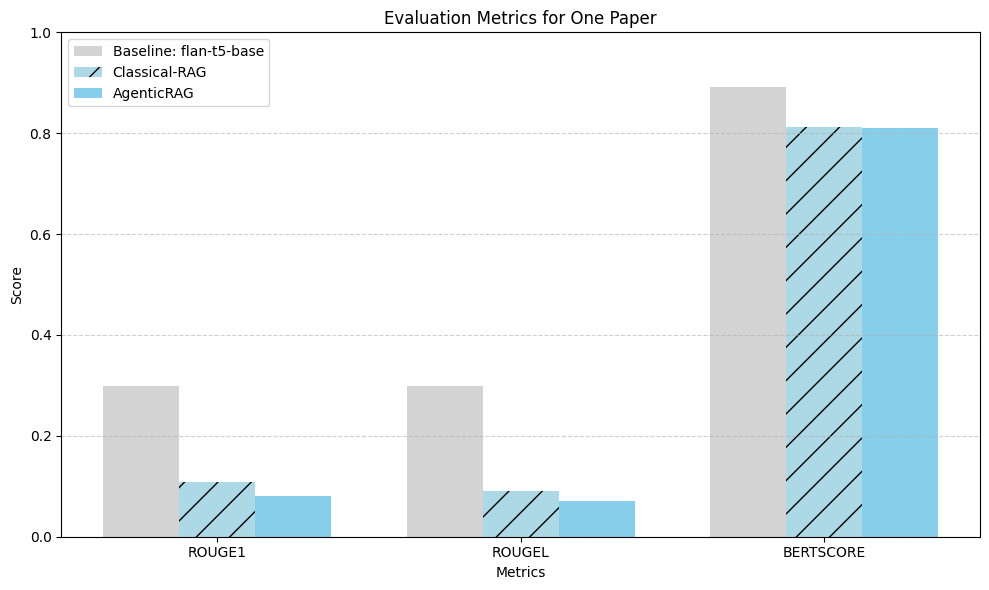

In [ ]:
plot_single_file_metrics(metrics)

# Testing

In [ ]:
# Testing on many queries
QUERIES = [
    "Summarize this paper in 200 words.",
    "What problem does this paper address and why is it important?",
    "Explain the main methodology used in this paper.",
    "What are the main results and contributions of this paper?"
]

def evaluate_all_queries():
    pdf_path = "/content/drive/MyDrive/Colab Notebooks/data/A Framework for Fine-Tuning LLMs using Heterogeneo.pdf"
    doc_id = os.path.basename(pdf_path)
    all_metrics = {doc_id: {}}

    for query in QUERIES:
        print(f"\n📄 Evaluating | Query: {query}")
        metrics, baseline_summary, classical_summary, agentic_summary = process_and_evaluate(pdf_path, user_query=query)

        all_metrics[doc_id][query] = {
            "Baseline": metrics["Baseline"],
            "Classical-RAG": metrics["Classical-RAG"],
            "AgenticRAG": metrics["AgenticRAG"]
        }

    return all_metrics


In [ ]:


def plot_metrics_by_model_per_query(all_metrics, chunk_size=800, overlap=400):
    queries = QUERIES
    models = ["Baseline", "Classical-RAG", "AgenticRAG"]
    metrics_to_plot = ["rouge1", "rougeL", "bertscore"]

    for query in queries:
        x = np.arange(len(metrics_to_plot))  # Metrics as x-axis labels
        width = 0.25  # Width of each bar

        # Collect scores: models x metrics
        scores_matrix = []
        for model in models:
            metric_scores = []
            for metric in metrics_to_plot:
                scores = [
                    all_metrics[doc][query][model][metric]
                    for doc in all_metrics if query in all_metrics[doc]
                ]
                metric_scores.append(np.mean(scores))
            scores_matrix.append(metric_scores)

        # Plot
        plt.figure(figsize=(10, 6))
        plt.bar(x - width, scores_matrix[0], width, label="Baseline: flan-t5-base", color="lightgray")
        plt.bar(x,         scores_matrix[1], width, label="Classical-RAG", color="lightblue", hatch='/')
        plt.bar(x + width, scores_matrix[2], width, label="AgenticRAG", color="skyblue")

        # Labels and formatting
        plt.title(f"Chunk size = {chunk_size}, Overlap = {overlap}, Query = \"{query}\"")
        plt.xticks(x, [m.upper() for m in metrics_to_plot])
        plt.ylabel("Average Score (%)")
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()


In [ ]:


def plot_metrics_by_model_per_query_inOne(all_metrics, chunk_size=800, overlap=400):
    queries = QUERIES  # Make sure this is defined with your 4 queries
    models = ["Baseline", "Classical-RAG", "AgenticRAG"]
    metrics_to_plot = ["rouge1", "rougeL", "bertscore"]

    # Create a single figure with 4 subplots (2 rows, 2 columns)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"Performance Comparison Across All Queries (Chunk Size = {chunk_size}, Overlap = {overlap})",
                 fontsize=14, y=1.02)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, query in enumerate(queries):
        ax = axes[i]
        x = np.arange(len(metrics_to_plot))  # Metrics as x-axis labels
        width = 0.25  # Width of each bar

        # Collect scores: models x metrics
        scores_matrix = []
        for model in models:
            metric_scores = []
            for metric in metrics_to_plot:
                scores = [
                    all_metrics[doc][query][model][metric]
                    for doc in all_metrics if query in all_metrics[doc]
                ]
                metric_scores.append(np.mean(scores))
            scores_matrix.append(metric_scores)

        # Plot bars
        ax.bar(x - width, scores_matrix[0], width, label="Baseline (Mistral)", color="lightgray")
        ax.bar(x,         scores_matrix[1], width, label="Classical-RAG", color="lightblue", hatch='/')
        ax.bar(x + width, scores_matrix[2], width, label="AgenticRAG", color="skyblue")

        # Subplot formatting
        ax.set_title(f'Query {i+1}: {query[:20]}...' if len(query) > 20 else f'Query {i+1}: {query}')
        ax.set_xticks(x, [m.upper() for m in metrics_to_plot])
        ax.set_ylabel("Average Score (%)")
        ax.set_ylim(0, 1)
        ax.grid(axis='y', linestyle='--', alpha=0.6)

        # Only show legend on first subplot to avoid repetition
        if i == 0:
            ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

    plt.tight_layout()
    plt.show()


📄 Evaluating | Query: Summarize this paper in 200 words.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📄 Evaluating | Query: What problem does this paper address and why is it important?


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📄 Evaluating | Query: Explain the main methodology used in this paper.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📄 Evaluating | Query: What are the main results and contributions of this paper?


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


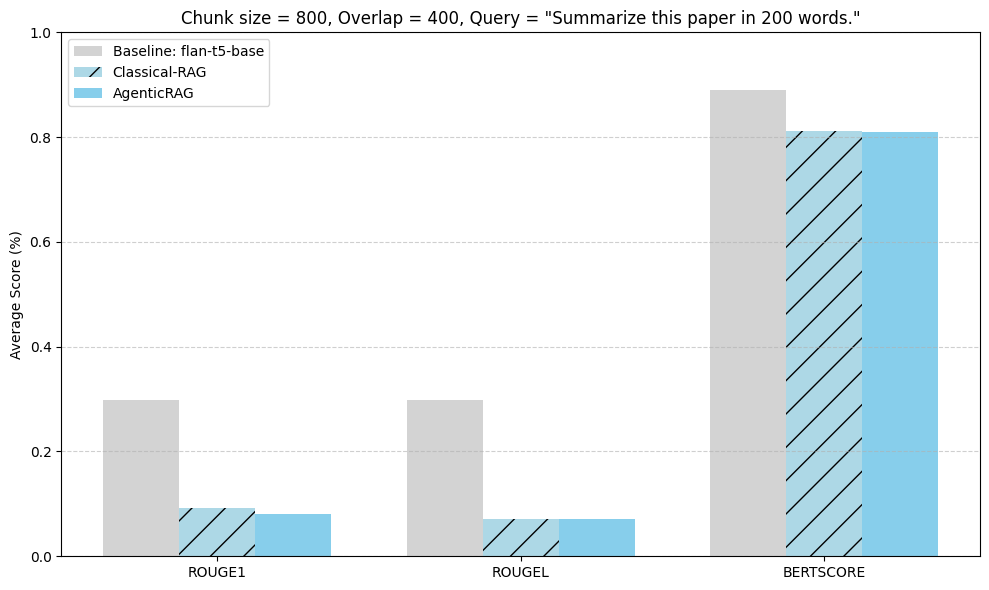

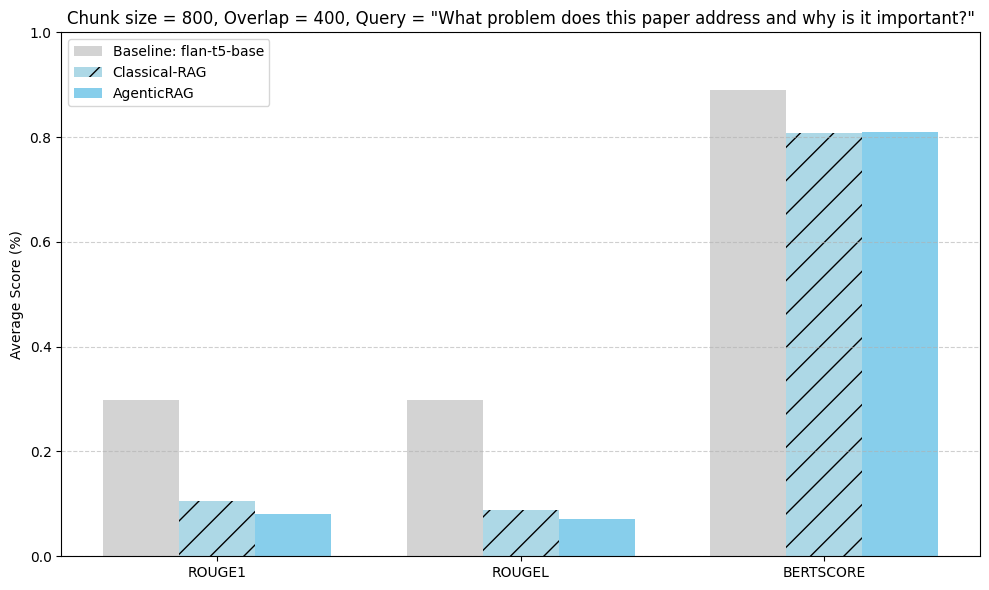

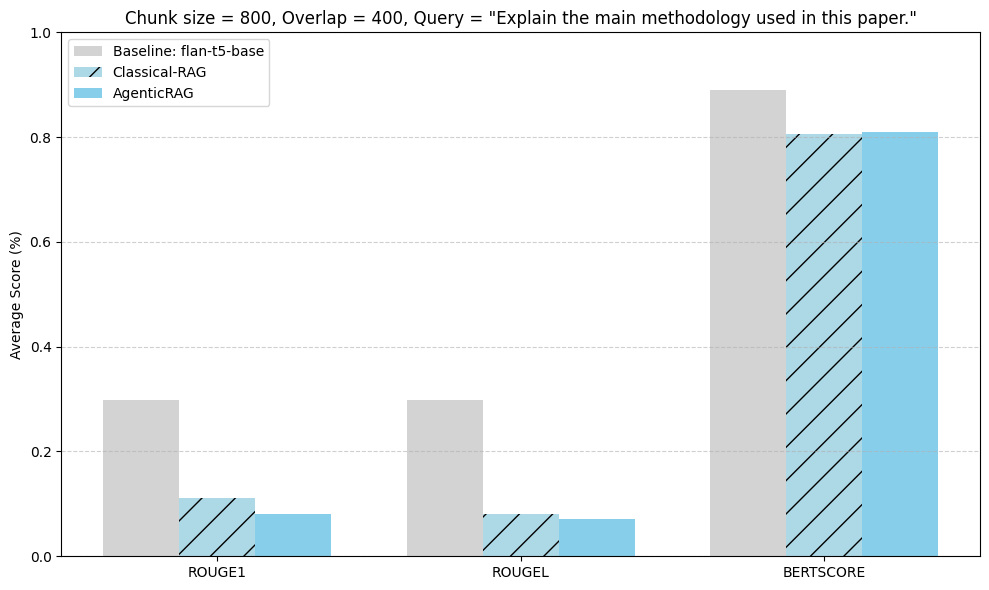

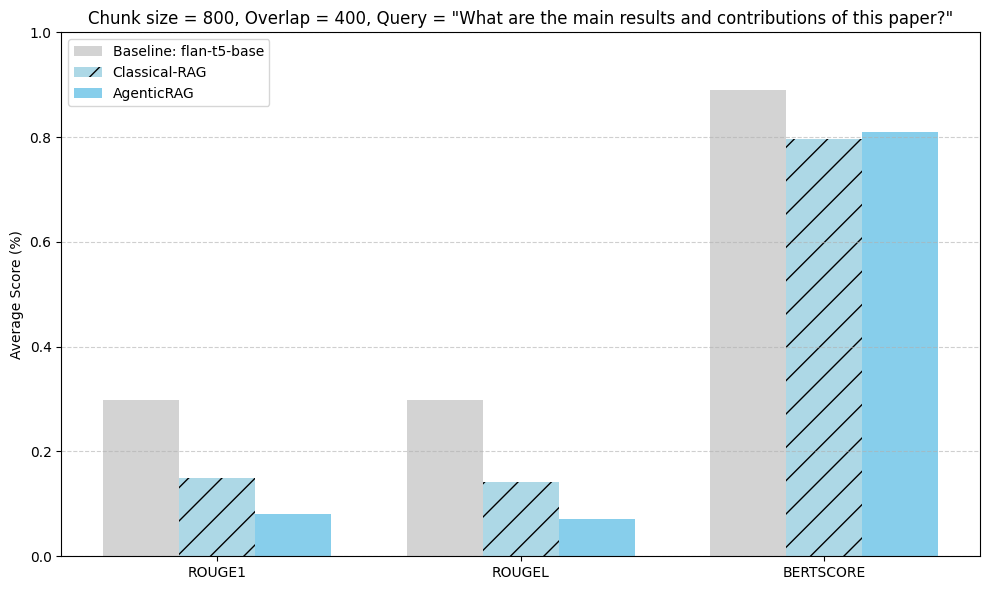

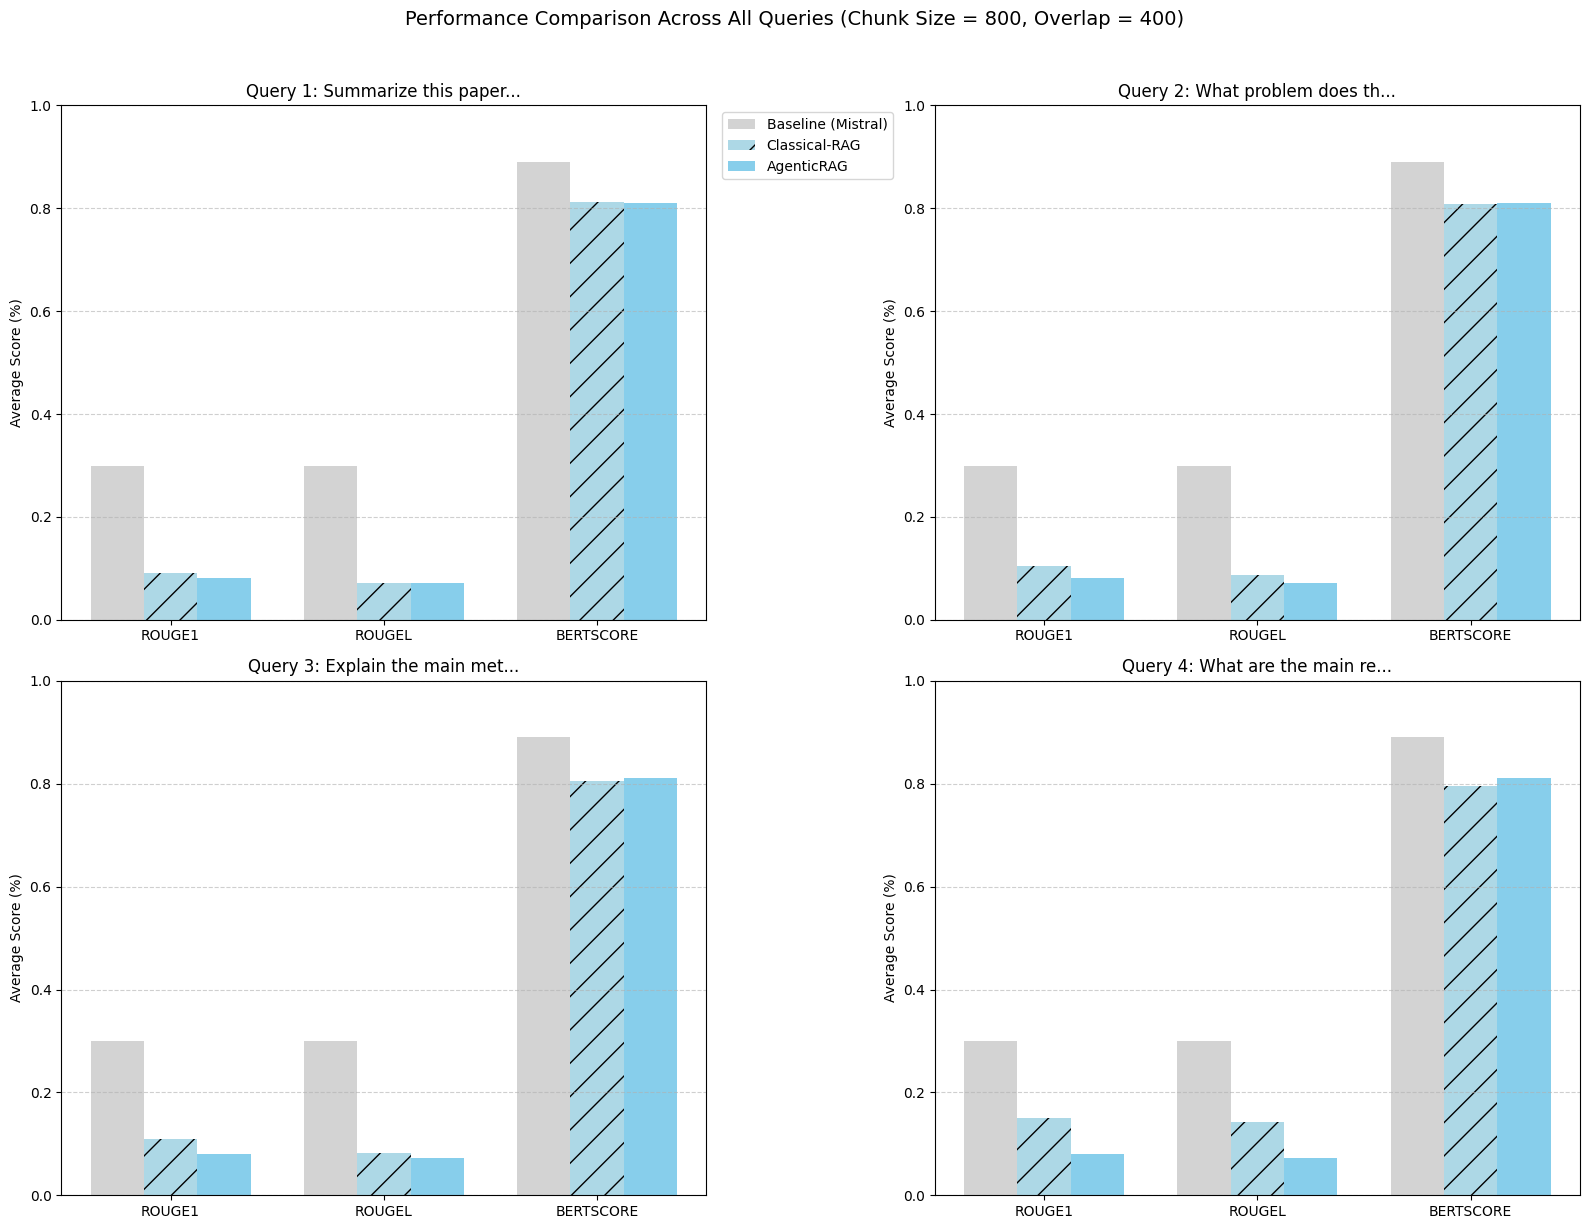

In [ ]:
all_metrics = evaluate_all_queries()
plot_metrics_by_model_per_query(all_metrics)
plot_metrics_by_model_per_query_inOne(all_metrics)


## Graph RAG Pipeline